In [1]:
!pip install -U scikit-learn scipy matplotlib tensorflow scikeras pydot graphviz


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

cf10_classes = ['airplan','auto','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(cf10_classes)

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print("Original train size = ",X_train.shape)
print("Original test size = ",X_test.shape)

x_train, x_test, y_train, y_test=train_test_split(X_train, Y_train, test_size=0.90, random_state=42, shuffle=True)
x_test, x_valid, y_test, y_valid=train_test_split(x_test, y_test, test_size=0.95, random_state=42, shuffle=True)
print("Train size = ",x_train.shape)
print("Test size = ",x_test.shape)
print("Valid size = ",x_valid.shape)

y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
y_valid = to_categorical(y_valid,num_classes)



2023-10-02 21:45:16.601957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:45:16.641275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-02 21:45:16.641313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-02 21:45:16.641342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 21:45:16.649386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:45:17.504031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Original train size =  (50000, 32, 32, 3)
Original test size =  (10000, 32, 32, 3)
Train size =  (5000, 32, 32, 3)
Test size =  (2250, 32, 32, 3)
Valid size =  (42750, 32, 32, 3)


In [3]:
from tensorflow.keras.layers import Activation, Rescaling
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

input_shape=x_train.shape[1:]
print ("The input shape: ",input_shape)

def make_model ():
    model = Sequential()
    # 1 picture * 3 colors * 32 filters * 9 kernel points + 32 filter thresholds = 896 parameters
    # 32x32 inputs => 30x30inputs
    model.add (Rescaling(1./255, input_shape=input_shape))
    model.add (Conv2D(filters=32,kernel_size=(3,3), input_shape=input_shape))
    model.add (Activation('relu'))
    # 32 previous filtered pictures * 9 kernel points * 24 filters + 24 filter threshods = 6936 parameters
    # 30x30 inputs => 28*28
    model.add (Conv2D(filters=24,kernel_size=(3,3)))
    model.add (Activation('relu'))
    # 28х28 inputs => 14х14
    model.add (MaxPooling2D(pool_size=(2,2)))
    model.add (Dropout(0.1))

    # 24 previous filtered pictures * 9 kernel points * 16 filters + 16 filters thresholds = 3472
    # 14x14 inputs => 12x12
    model.add (Conv2D(filters=16,kernel_size=(3,3)))
    model.add (Activation('relu'))
    # 12x12 inputs 6x6 = 36 points
    model.add (MaxPooling2D(pool_size=(2,2)))
    model.add (Dropout(0.1))

    # 16 filtered pictures x 36 points *100 elements + 100 thresholds 57600
    model.add (Flatten())
    model.add (Dense(100))
    model.add (Activation('relu'))
    model.add (Dropout(0.1))
    # 100t vector * 10 elements +10 thresholds = 1010
    model.add (Dense(num_classes))
    model.add (Activation('softmax'))
    return model;

def make_model_2 ():
    model = Sequential([
        Rescaling(1./255, input_shape=input_shape), #(img_height, img_width, 3)),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(150, activation='relu'),
        Dense(num_classes,activation='softmax')])
    
    return model;
   
model =make_model_2()
model.summary()



The input shape:  (32, 32, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)        

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
hist = model.fit(x_train,y_train,epochs=50,batch_size=100,validation_data=(x_test,y_test),verbose=0)

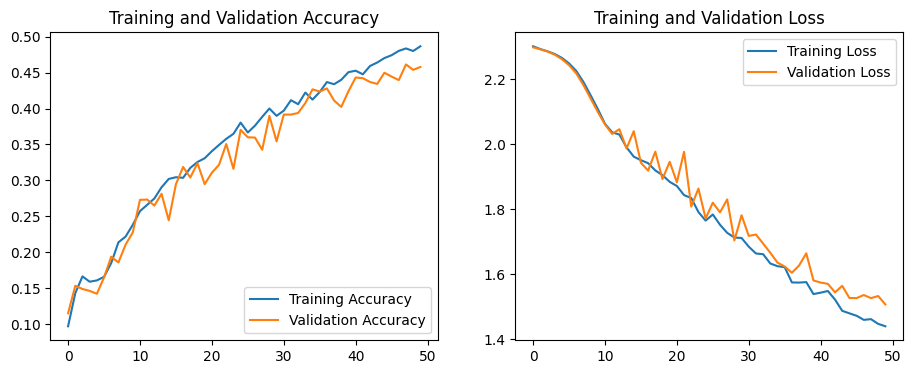

In [8]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def make_compiled_model (loss='categorical_crossentropy',optimizer='sgd',metrics='accuracy') :
    model = make_model_2();
    model.compile(loss=loss,optimizer=optimizer,metrics=[metrics])
    return model

def print_results (grid_result):
    print("  --> Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      > %f (%f) with: %r" % (mean, stdev, param))

keras_classifier = KerasClassifier(model=make_compiled_model, verbose=0)

batch_size = [100, 250, 500, 750, 1000]
epochs = [50, 100, 150, 200, 250]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, n_jobs=-1, cv=3, verbose=0)
grid_result = grid.fit(x_train, y_train)

print_results(grid_result);

2023-10-02 21:55:51.866587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.866706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.873004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.887682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.923558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.923556: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 21:55:51.936557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one 

In [1]:

keras_classifier = KerasClassifier(model=create_model_without_compile, loss="binary_crossentropy",
                                   epochs=100, batch_size=50, verbose=0)

# define the grid search parameters
optimizer = ['Adadelta','Adafactor','Adagrad','Adam','AdamW','Adamax', 'Ftrl','Lion', 'Nadam','SGD', 'RMSprop']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print_results(grid_result);


# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# https://www.tensorflow.org/tutorials/images/classification


NameError: name 'KerasClassifier' is not defined